IMPORT MODULES

In [82]:
import torch
from torch import nn
from torchmetrics import Accuracy

from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from helper_functions import plot_decision_boundary

HYPERMARAMETERS

In [88]:
LEARNING_RATE = 0.1
INPUT_SHAPE = 2
HIDDEN_UNITS = 10
OUTPUT_SHAPE = 6
EPOCHS = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CREATE DATASET

In [89]:
X, y = make_gaussian_quantiles(n_samples=2000,
                               n_features=2,
                               n_classes=6,
                               shuffle=True,
                               random_state=402)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
X.shape, y.shape

(torch.Size([2000, 2]), torch.Size([2000]))

VISUALIZE DATA

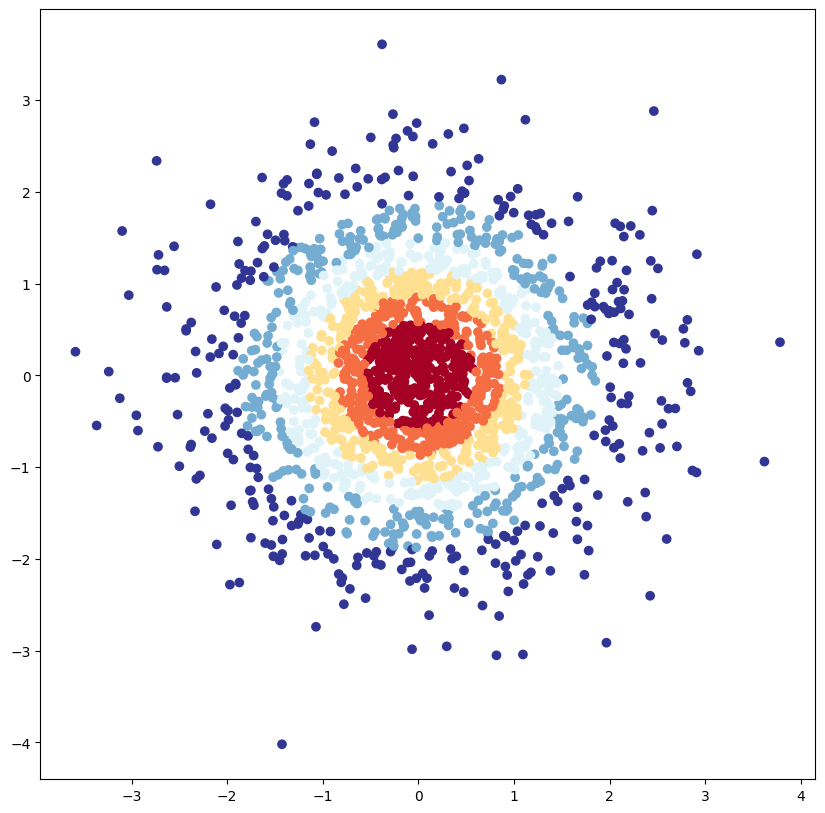

In [90]:
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

CREATE A MODEL

In [91]:
class GaussianClassificationModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layers_stack(x)
    
model = GaussianClassificationModel(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE).to(DEVICE)
model.state_dict()

OrderedDict([('layers_stack.0.weight',
              tensor([[ 0.0864, -0.3680],
                      [-0.3693,  0.0187],
                      [ 0.3794,  0.4505],
                      [-0.5008,  0.2424],
                      [-0.6717,  0.0344],
                      [-0.4178,  0.4483],
                      [ 0.6610,  0.7025],
                      [-0.0513,  0.2511],
                      [-0.3938,  0.3337],
                      [ 0.2070, -0.4164]])),
             ('layers_stack.0.bias',
              tensor([-0.0273,  0.5014,  0.5286,  0.1570,  0.0751, -0.6947,  0.2893,  0.1173,
                       0.4551,  0.3687])),
             ('layers_stack.2.weight',
              tensor([[-0.1453,  0.2173,  0.0021, -0.1908,  0.2085,  0.1145, -0.2023, -0.2239,
                        0.0128, -0.2562],
                      [-0.0890, -0.1320, -0.1940, -0.2504,  0.2156, -0.1403,  0.1459,  0.0825,
                        0.2966, -0.1638],
                      [-0.1455,  0.1632,  0.1366,  

TRAINING LOOP

In [92]:
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=6)
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=LEARNING_RATE)

for epoch in range(1, EPOCHS+1):
    model.train()

    y_train_logits = model(X_train)
    y_train_pred = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(y_train_logits, y_train)
    train_acc = accuracy(y_train_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy(y_test_pred, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc}")


Epoch: 100 | Train Loss: 1.74 | Train Acc: 0.24937500059604645 | Test Loss: 1.74 | Test Acc: 0.2150000035762787
Epoch: 200 | Train Loss: 1.58 | Train Acc: 0.38749998807907104 | Test Loss: 1.59 | Test Acc: 0.36250001192092896
Epoch: 300 | Train Loss: 1.34 | Train Acc: 0.48249998688697815 | Test Loss: 1.36 | Test Acc: 0.46000000834465027
Epoch: 400 | Train Loss: 1.16 | Train Acc: 0.6100000143051147 | Test Loss: 1.18 | Test Acc: 0.5924999713897705
Epoch: 500 | Train Loss: 1.02 | Train Acc: 0.7162500023841858 | Test Loss: 1.04 | Test Acc: 0.7124999761581421
Epoch: 600 | Train Loss: 0.87 | Train Acc: 0.8056250214576721 | Test Loss: 0.89 | Test Acc: 0.8100000023841858
Epoch: 700 | Train Loss: 0.70 | Train Acc: 0.8681250214576721 | Test Loss: 0.72 | Test Acc: 0.8600000143051147
Epoch: 800 | Train Loss: 0.56 | Train Acc: 0.9106249809265137 | Test Loss: 0.58 | Test Acc: 0.9200000166893005
Epoch: 900 | Train Loss: 0.45 | Train Acc: 0.9262499809265137 | Test Loss: 0.47 | Test Acc: 0.9225000143051

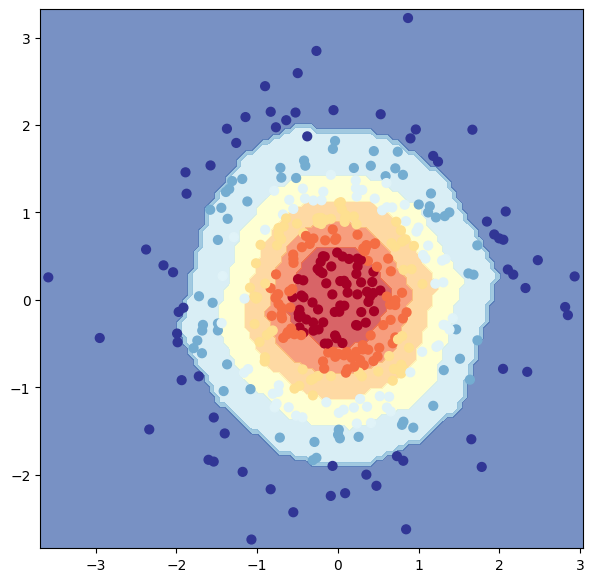

In [95]:
plt.figure(figsize=(7, 7))
plot_decision_boundary(model=model, X=X_test, y=y_test)